# Problem 0, CNN
This notebook solves the problem of multiclass classification. It will classify 3 different classes of input images - squares, triangles and lines. The Given, Find, Structure of this submission is seperated into seperate tasks that you're introduced to throughout the Jupyter Notebook.



In [1]:
import numpy as np
import utils

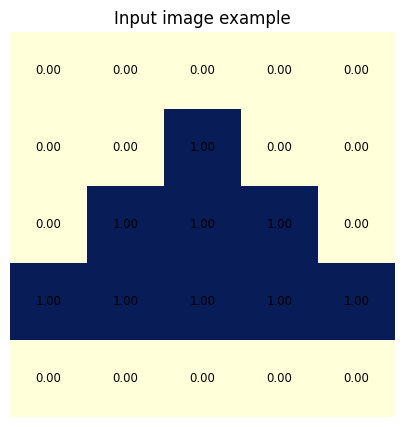

In [2]:
# Input: random 5x5 integer matrix
# 3 classes: Triangle (0),  Line (1), Square (2)
# The shape of the input matrix is (1, 5, 5) and not (5, 5) because we can later generalize to images with more than one channel
input_triangle = np.array([[
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0]
]])
input_line = np.array([[
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0]
]])
input_square = np.array([[
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
]])

TRIANGLE = np.array([1., 0., 0.])
LINE = np.array([0., 1., 0.])
SQUARE = np.array([0., 0., 1.])
images = np.array([input_triangle, input_line, input_square])
labels = np.array([TRIANGLE, LINE, SQUARE]).reshape(3, 3, 1)

(x_train, y_train) = (np.array(images), np.array(labels))
(x_test, y_test) = (np.array(images), np.array(labels))

utils.display_images([(images[0, 0], "Input image example")], figsize=(5, 5))

In [3]:
# https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
# https://github.com/macbuse/macbuse.github.io/blob/master/PROG/convolve.py
def convolve2D(image: np.ndarray, kernel: np.ndarray, mode = "valid", correlation = False):
    # Cross correlation or Convolution depends on the orientation of the kernel
    kernel = kernel if correlation else np.flipud(np.fliplr(kernel))

    # Gather shapes of kernel + image + padding
    x_kernel_size, y_kernel_size = kernel.shape
    x_image_size, y_image_size = image.shape[0:2]

    if mode == "valid":
        # Ouput matrix size of a full convolution
        x_output = int(x_image_size - x_kernel_size + 1)
        y_output = int(y_image_size - y_kernel_size + 1)
        output = np.zeros((x_output, y_output))

        for y in range(0, y_image_size - y_kernel_size + 1):
            for x in range(0, x_image_size - x_kernel_size + 1):
                output[x, y] = (kernel * image[x: x + x_kernel_size, y: y + y_kernel_size]).sum()
    
    elif mode == "full":
        # Output matrix size of a valid convolution
        x_output = int((x_image_size + x_kernel_size - 1))
        y_output = int((y_image_size + y_kernel_size - 1))
        image_padded = np.pad(image, x_kernel_size - 1, mode='constant', constant_values=(0))
        output = np.zeros((x_output, y_output))

        for x in range(0, output.shape[0]):
            for y in range(0, output.shape[1]):
                output[x, y] = (kernel * image_padded[x: x + x_kernel_size, y: y + y_kernel_size]).sum()
        
    return output

# Task 1.0

### Given
- A dataset containing 3 different classes of images

### Find
- Apply the convolve2D-function to one of the input images with a specified kernel.
- Apply the same convolve2D-function, but with the optional parameter `correlation = True`
- Visualize the images leveraging `utils.display_images`

### Solution
Simply apply the `convolve2D`-function to the image. This will compute $output = image * kernel$

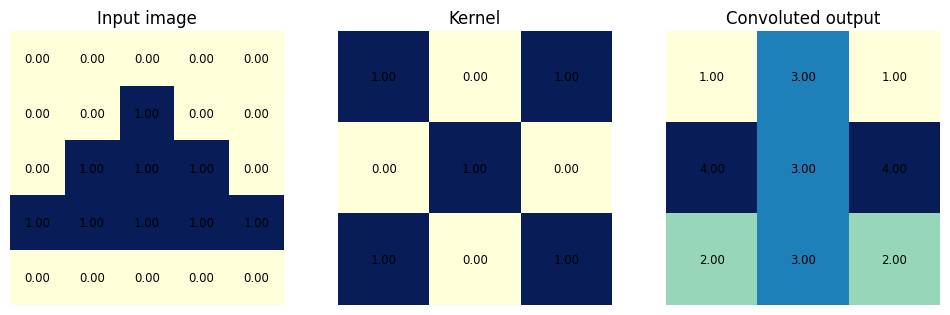

In [4]:
# 2x2 filter
kernel = np.array([[1, 0], [1, 0]])

# 3x3 filter
kernel = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])

convoluted_output = convolve2D(images[0, 0], kernel, mode = 'valid', correlation = True)
utils.display_images([(images[0, 0], "Input image"), (kernel, "Kernel"), (convoluted_output, "Convoluted output")])

## Task 1.1

### Given
- A skeleton for a `Layer`-class, as found in the code-block beneath

### Find
- Implement the `forward`- and `backward`-method in the `Dense` class

### Solution
The forward-method of the Dense layer is simply the dot-product between the weights and inputs added to the bias:
$$\vec{weights} \cdot \vec{input} + bias$$

The backward-method of the Dense layer is computed by:
$$\vec{weights\_gradient} = \vec{output\_gradient} \cdot \vec{input^T}$$
$$\vec{weights} = \vec{weights} - \alpha * \vec{weights\_gradient} \;,\; \alpha = learning rate$$

In [5]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

In [6]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
    
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias
    
    def backward(self, output_gradient, learning_rate):
        # Update params and return input gradient
        weights_gradient = np.dot(output_gradient, self.input.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return np.dot(self.weights.T, output_gradient)

## Task 1.2

### Given
- A skeleton of a `Activation`-class

### Find
- Implement the `forward`-method in the `Sigmoid`-class
- Implement the `forward`-method in the `Softmax`-class

### Solution
The sigmoid activation function, and hence the `forward`-method, is:
$${\displaystyle S(x)={\frac {1}{1+e^{-x}}}={\frac {e^{x}}{e^{x}+1}}=1-S(-x).}$$

The `backward`-method for the Sigmoid-class by finding derivative of the sigmoid-function:
$$S'(x) = S(x) * (1 - S(x))$$

In [7]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(self.input)
    
    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [8]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)
            
        super().__init__(sigmoid, sigmoid_prime)

In [9]:
class Tanh(Activation):
    def __init__(self):
        tanh = lambda x: np.tanh(x)
        tanh_prime = lambda x: 1 - np.tanh(x)**2
        super().__init__(tanh, tanh_prime)

In [10]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        tmp = np.tile(self.output, n)
        return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

## Task 1.3

### Given
- A skeleton of a `Layer`- and `Convolutional`-class

### Find
- Implement the `forward`-method in the `Convolutional`-class

### Solution
The `forward`-method is implemented by leveraging `convolve2D`.

In [11]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth # number of kernels
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size) # multiple 3D kernels
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)
    
    
    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += convolve2D(self.input[j], self.kernels[i, j])
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = convolve2D(self.input[j], output_gradient[i], "valid", correlation = True)
                input_gradient[j] += convolve2D(output_gradient[i], self.kernels[i, j], "full")
        
        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient



In [12]:
class Maxpool(Layer):
    def __init__(self, input_size, output_size, k=2, stride=1):
        self.input_size = input_size
        self.output_size = output_size
        self.k = k
        self.stride = stride
    
    
    def forward(self, input):
        h_out = (input[0].shape[0] - self.k) // self.stride + 1
        w_out = (input[0].shape[1] - self.k) // self.stride + 1
        
        self.output = np.zeros((input.shape[0], h_out, w_out))
        self.output_size = self.output.shape
        self.idx = []

        for channel in range(input.shape[0]):
            for j in range(0, h_out):
                for i in range(0, w_out):
                    block = input[channel][j:j+self.k, i:i+self.k]
                    self.output[channel][j, i] = np.max(block)
                    index = np.add(np.unravel_index(np.argmax(block), block.shape), (j, i))
                    self.idx.append(index)
        
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        d = np.zeros(self.input_size)
        for channel in range(self.output_size[0]):
            for idx, value in zip(self.idx, output_gradient.flatten()):
                i, j = idx[0], idx[1]
                d[channel][i, j] = value
        return d

In [13]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    
    def forward(self, input):
        return np.reshape(input, self.output_shape)
    
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

## Task 1.5

### Loss functions
There are a multitude of loss functions, each for its own purpose. I'll later provide 3 examples, 2 approaches to solve binary classification - one with only a FCNN, another with a CNN with binary classification. Last, a CNN with multiclass classification. Each of the different examples have a fitting loss function.

Binary classification: MSE or Binary cross entropy
Multiclass classification: Cross entropy

### Given
- `y_true` and `y_pred` as input. Both are np.ndarray with shape (3, 1)

### Find
- Implement a function for `cross_entropy(y_true, y_pred)` which returns the cross_entropy between the predicted and true values.

### Solution
The cross entropy, $CE$, can be found with the following formula:
$${\displaystyle CE(y_{true}, y_{pred})=-\sum _{x\in {\mathcal {X}}}y_{true}\,\log{(y_{pred})}}$$

In [14]:
def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

def cross_entropy(y_true, y_pred):
    # Make sure not to take log(0) by adding a small value to y_pred
    return -np.sum(y_true * np.log(y_pred + 10**-100))

def cross_entropy_prime(y_true, y_pred):
    # Make sure not to divide by 0 by adding a small value to y_pred
    return - y_true / (y_pred + 10**-100)

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

# Multiclass Classification Problem

### Given
- Training- and test-data in `(x_train, y_train)` and `(x_test, y_test)`
- The implemented classes `Convolutional`, `Sigmoid`, `Reshape` and `Softmax`
- A CNN with the following architecture and cross entropy loss function

|     Layer     | Output Shape | Kernel Size | Stride | Padding | Activation function |
|:-------------:|:------------:|:-----------:|:------:|:-------:|---------------------|
| Input         |   (1, 5, 5)  |      -      |    -   |    -    |          -          |
| Convolutional |   (5, 4, 4)  |     2x2     |    1   |    0    |       Sigmoid       |
| Maxpool       |   (5, 3, 3)  |     2x2     |    1   |    0    |          -          |
| Flatten       |    (45, 1)   |      -      |    -   |    -    |          -          |
| Dense         |   (45, 10)   |      -      |    -   |    -    |       Sigmoid       |
| Dense         |    (10, 3)   |      -      |    -   |    -    |       Softmax       |


### Find
- The intermediate kernels, gradients and outputs during training.

### Solution

#### Initialization of network
The network is initialized by passing the correct dimensions to the different implementations of `Layer` and `Activation`. In order to solve the multiclass classification task, a CNN with the aforementioned architecture is initialized.

#### Forward pass
By leveraging the Layer-class' already implemented `forward`-method the task is simply to retrieve the intermediate values and visualize them.

#### Backward pass
In order to perform the backward pass we need to compute the error **L** and pass it backwards through the network by calculating the partial derivatives for each of the activations/layers. This process is well described by the following image:

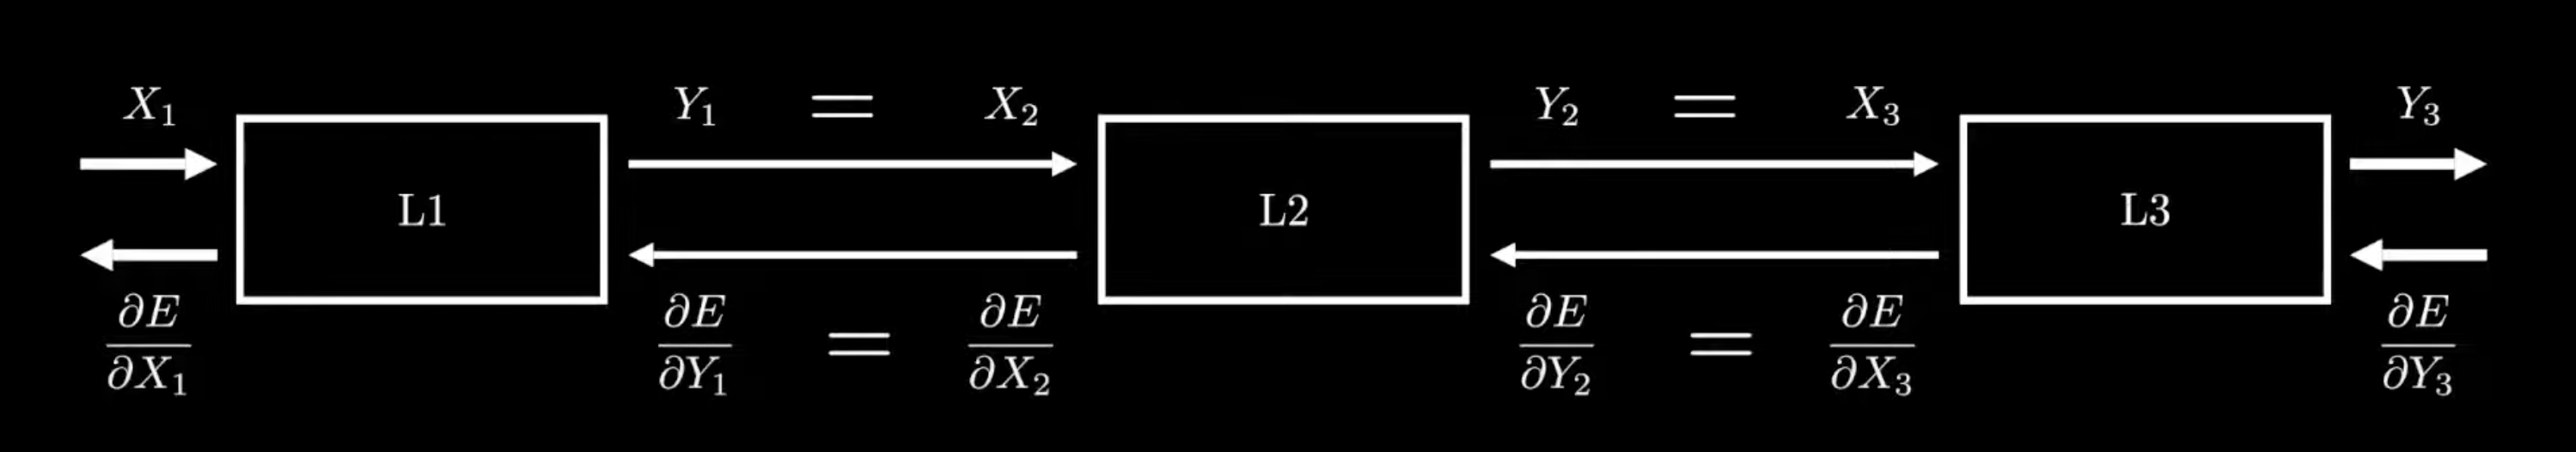

The way we've structured the classes, this is effortlessly done by leveraging the classes' `backward`-methods. We traverse the network in reversed order and each layer/activation calculates the error with regard to its parameters.




In [15]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 301
VISUALIZE_INTERVAL = 100

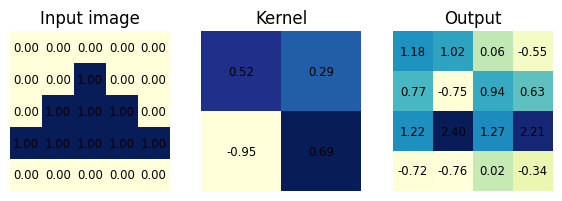

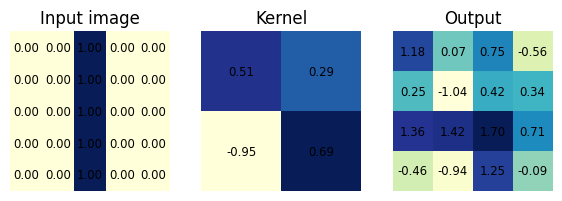

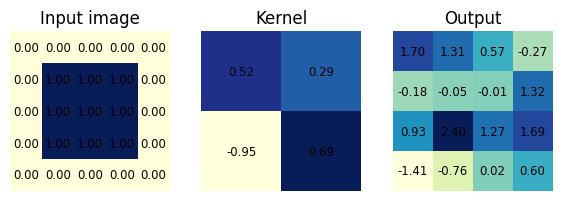

Epoch 0, error: 1.33435581417815


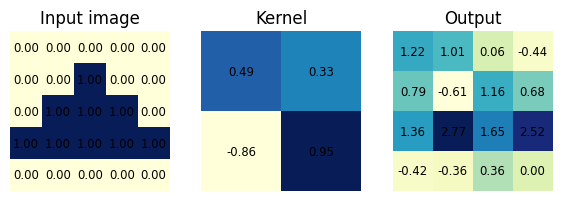

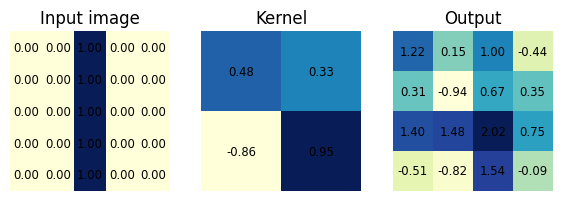

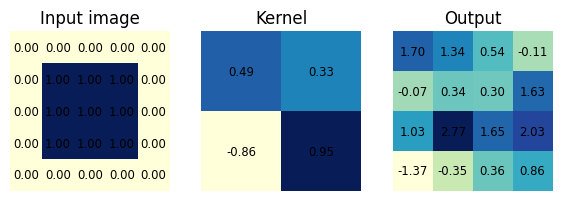

Epoch 100, error: 0.8994280336239502


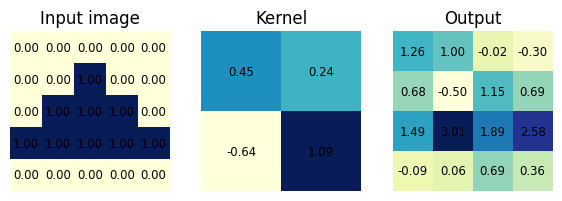

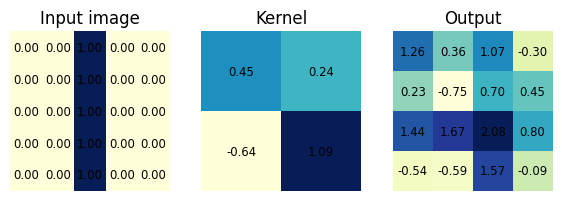

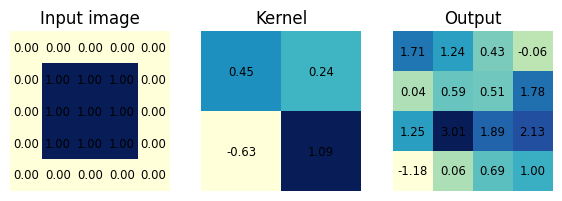

Epoch 200, error: 0.8911988982208018


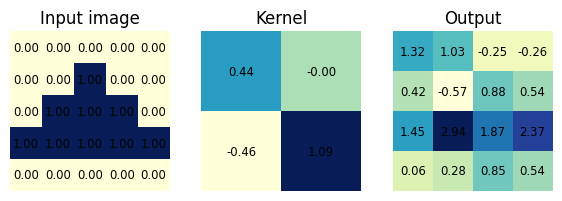

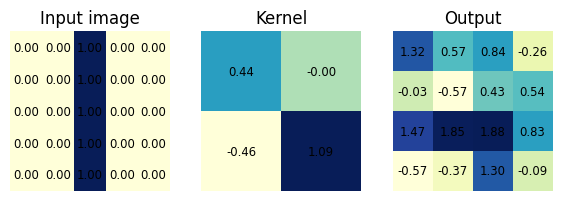

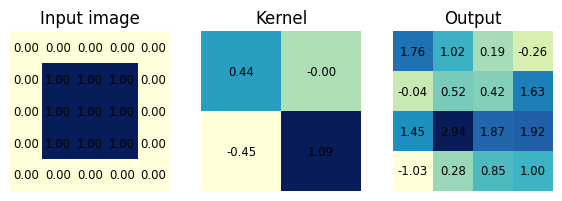

Epoch 300, error: 0.8048661480615765
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 2, actual: 2


In [16]:
network = [
    Convolutional((1, 5, 5), 2, 5),
    Sigmoid(),
    Maxpool((5, 4, 4), (5, 3, 3), k = 2, stride = 1),
    Reshape((5, 3, 3), (5 * 3 * 3, 1)),
    Dense(5 * 3 * 3, 10),
    Sigmoid(),
    Dense(10, 3),
    Softmax()
]

for epoch in range(EPOCHS):
    error = 0
    for x, y in zip(x_train, y_train):
        # Forward pass
        output = x

        for layer in network:
            temp_output = output
            output = layer.forward(output)

            # Visualize how the kernel convolutes the input image
            if (epoch % VISUALIZE_INTERVAL == 0 and layer.__class__ == Convolutional):
                utils.display_images([(temp_output[0], "Input image"), (layer.kernels[0, 0], "Kernel"), (output[0], "Output")], figsize=(7, 7))

        
        # Calculate error
        error += cross_entropy(y, output)

        # Backward pass
        grad = cross_entropy_prime(y, output)
        
        for layer in reversed(network):
            grad = layer.backward(grad, LEARNING_RATE)
        
    error /= len(x_train)
    if (epoch % VISUALIZE_INTERVAL == 0):
        print(f"Epoch {epoch}, error: {error}")

for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
        output = layer.forward(output)
    print(f"Predicted: {np.argmax(output)}, actual: {np.argmax(y)}")

---
*This part can be skipped, but I've chosen to include it to showcase some extra possibilities of a framework like this*

# Extra problems

### XOR-problem using a FCNN
Example of how we can use the network to train a simple, FCNN which solves the XOR-problem

In [17]:
X = np.reshape([[0,0], [0,1], [1,0], [1,1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

In [18]:
network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

In [19]:
epochs = 100
learning_rate = 0.1

In [20]:
for epoch in range(epochs):
    error = 0
    for x, y in zip(X, Y):
        # Forward pass
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # Calculate error
        error += mse(y, output)

        # Backward pass
        grad = mse_prime(y, output)
        
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
        
    error /= len(X)
    if (epoch % VISUALIZE_INTERVAL == 0):
        print(f"Epoch {epoch}, error: {error}")

Epoch 0, error: 1.1020790763794428


# MNIST Problem

Example of how the same network can be used to solve the MNIST problem. In order to reduce the complexity and training time, the training data is reduced from 10 classes to 2, and we only train on 100 of the images. The training still takes quite long time due to the unoptimized implementations of e.g. convolve2D, etc.

In [21]:
from keras.datasets import mnist
from keras.utils import np_utils

2022-10-12 20:59:51.902995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype('float32') / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

In [23]:
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

epochs = 10
learning_rate = 0.1

for epoch in range(epochs):
    error = 0
    for x, y in zip(x_train, y_train):
        # Forward pass
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # Calculate error
        error += binary_cross_entropy(y, output)

        # Backward pass
        grad = binary_cross_entropy_prime(y, output)
        
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
    
    error /= len(x_train)
    print(f"Epoch {epoch}, error: {error}")

correct = 0
for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
        output = layer.forward(output)
        correct += 1 if np.argmax(output) == np.argmax(y) else 0

print(f"\nNumber of correct predictions: {correct}")

Epoch 0, error: 0.3793958684522768
Epoch 1, error: 0.07196206731254921
Epoch 2, error: 0.022214499769619644
Epoch 3, error: 0.014907077546297033
Epoch 4, error: 0.011356150500642767
Epoch 5, error: 0.00909772251149349
Epoch 6, error: 0.0075301587875256535
Epoch 7, error: 0.006383834452245532
Epoch 8, error: 0.0055596015939730495
Epoch 9, error: 0.0048979771387935985

Number of correct predictions: 396


# Resources
Inspiration is taken from:
- [The Independent Code, YouTube series on "Convolutional Neural Network from Scratch"](https://www.youtube.com/watch?v=Lakz2MoHy6o&ab_channel=TheIndependentCode)
- [2D Convolution using Python & NumPy](https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381)
